In [14]:
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### NNLM model

- 예문 : "what will the fat cat sit on"
- input : 'what will the fat cat'
- output(예측값) : 'sit'

<br>

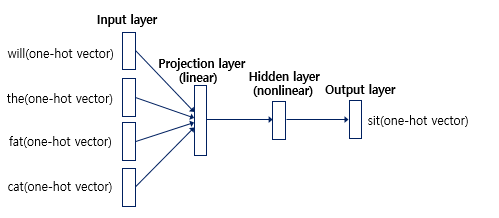

In [36]:
# bath size 설정
def make_batch():
    input_batch = []
    target_batch = []

    for sen in sentences:
        word = sen.split()  # 입력된 문장을 띄워쓰기 기반 단어 단위로 짜름
        input_w = [word_dict[n] for n in word[:-1]]  # 다음 단어 예측을 위해 입력되는 단어는 1 ~ n-1
        target = word_dict[word[-1]]  # 예측해야 하는 다음 단어

        input_batch.append(input_w)
        target_batch.append(target)
        
    return input_batch, target_batch

In [44]:
class NNLM(nn.Module):
    def __init__(self):
        super(NNLM, self).__init__()
        self.C = nn.Embedding(n_class, m)  # embedding할 단어 개수, embedding할 vector의 차원
        self.H = nn.Linear(n_step*m, n_hidden, bias=False) 
        self.d = nn.Parameter(torch.ones(n_hidden))
        self.U = nn.Linear(n_hidden, n_class, bias=False)
        self.W = nn.Linear(n_step*m, n_class, bias=False)
        self.b = nn.Parameter(torch.ones(n_class))

    def forward(self, x):
        x = self.C(x)
        x = x.view(-1, n_step * m)  # x를 [batch_size, n_step*m] 형태로 변환
        tanh = torch.tanh(self.d + self.H(x))  # [batch_size, n_hidden]
        output = self.b + self.W(x) + self.U(tanh)  # [batch_size, n_class]
        return output  # y = b + Wx + U*tanh(d+Hx)

In [46]:
sentences = ["i like dog", "i love coffee", "i hate milk", "i read book", "i study englist"]

word_list = " ".join(sentences[:]).split() 
word_list = list(set(word_list))

word_dict = {w: i for i, w in enumerate(word_list)}
number_dict = {i: w for i, w in enumerate(word_list)}
n_class = len(word_dict)

print('-'*50)
print(f'Word Dictioinary: {word_dict}')
print('-'*50)
print(f'Number Dictioinary: {number_dict}')
print('-'*50)
print(f'Number of Class: {n_class}')
print('-'*50)

n_step = 2  # n-1
n_hidden = 2
m = 2  # embedding size

print()
print(NNLM())

model = NNLM()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

input_batch, target_batch = make_batch()
input_batch = torch.LongTensor(input_batch)  # int type의 tensor로 변경
target_batch = torch.LongTensor(target_batch)

--------------------------------------------------
Word Dictioinary: {'love': 0, 'dog': 1, 'like': 2, 'coffee': 3, 'hate': 4, 'i': 5, 'study': 6, 'milk': 7, 'book': 8, 'read': 9, 'englist': 10}
--------------------------------------------------
Number Dictioinary: {0: 'love', 1: 'dog', 2: 'like', 3: 'coffee', 4: 'hate', 5: 'i', 6: 'study', 7: 'milk', 8: 'book', 9: 'read', 10: 'englist'}
--------------------------------------------------
Number of Class: 11
--------------------------------------------------

NNLM(
  (C): Embedding(11, 2)
  (H): Linear(in_features=4, out_features=2, bias=False)
  (U): Linear(in_features=2, out_features=11, bias=False)
  (W): Linear(in_features=4, out_features=11, bias=False)
)


In [50]:
for epoch in range(5000):
    optimizer.zero_grad()
    output = model(input_batch)

    loss = criterion(output, target_batch)

    if (epoch + 1) % 1000 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

    loss.backward()
    optimizer.step()

pred = model(input_batch).data.max(1, keepdim=True)[1]

print('-'*50)

print([sen.split()[:2] for sen in sentences], '->', [number_dict[n.item()] for n in pred.squeeze()])

Epoch: 1000 cost = 0.001215
Epoch: 2000 cost = 0.000689
Epoch: 3000 cost = 0.000397
Epoch: 4000 cost = 0.000231
Epoch: 5000 cost = 0.000135
--------------------------------------------------
[['i', 'like'], ['i', 'love'], ['i', 'hate'], ['i', 'read'], ['i', 'study']] -> ['dog', 'coffee', 'milk', 'book', 'englist']
